In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn


In [1]:
path_1 = r'D:\sim-bench\outputs\siamese_e2e\20260105_151444\telemetry'
path_2 = r'D:\Projects\Series-Photo-Selection\outputs\siamese_e2e\20260105_153932\telemetry'

In [4]:
df_holdout_predictions_1 = pd.read_csv(os.path.join(path_1, 'holdout_predictions.csv'))
df_holdout_predictions_2 = pd.read_csv(os.path.join(path_2, 'holdout_predictions.csv'))

In [19]:
df_gradient_norms1 = pd.read_csv(os.path.join(path_1, 'gradient_norms.csv'))
df_gradient_norms2 = pd.read_csv(os.path.join(path_2, 'gradient_norms.csv'))

In [21]:
df_holdout_merged = df_gradient_norms1.merge(df_gradient_norms2.rename(
    columns={'overall': 'overall_ref',
             'backbone': 'backbone_ref',
             'head': 'head_ref'}), on=['batch_idx', 'epoch'])

In [22]:
df_holdout_merged.head()

,batch_idx,epoch,overall,backbone,head,overall_ref,backbone_ref,head_ref
0,10,0,2.543254,0.0,0.0,2.543267,0.0,0.0
1,20,0,4.324563,0.0,0.0,4.324552,0.0,0.0
2,30,0,7.289288,0.0,0.0,7.289330,0.0,0.0
3,40,0,6.880698,0.0,0.0,6.880961,0.0,0.0
4,50,0,6.905385,0.0,0.0,6.905345,0.0,0.0


In [20]:
df_gradient_norms2.head()

,batch_idx,epoch,overall,backbone,head
0,10,0,2.543267,0.0,0.0
1,20,0,4.324552,0.0,0.0
2,30,0,7.289330,0.0,0.0
3,40,0,6.880961,0.0,0.0
4,50,0,6.905345,0.0,0.0


In [5]:
df_holdout_predictions_1.head()

,batch_idx,epoch,image1,image2,label,prediction,logit_0,logit_1,correct
0,10,0,000015-01.jpg,000015-02.jpg,1,0,-0.011274,-0.014293,False
1,10,0,000015-01.jpg,000015-03.jpg,1,1,-0.335607,0.520945,True
2,10,0,000015-02.jpg,000015-03.jpg,1,1,-0.318790,0.525761,True
3,10,0,000047-01.jpg,000047-02.jpg,1,0,0.102205,-0.291472,False
4,10,0,000047-01.jpg,000047-03.jpg,1,0,-0.046537,-0.049950,False


In [6]:
df_holdout_predictions_2.head()

,batch_idx,epoch,image1,image2,label,prediction,logit_0,logit_1,correct
0,10,0,000015-01.jpg,000015-02.jpg,1,0,-0.007039,-0.014443,False
1,10,0,000015-01.jpg,000015-03.jpg,1,1,-0.339268,0.522047,True
2,10,0,000015-02.jpg,000015-03.jpg,1,1,-0.326686,0.527013,True
3,10,0,000047-01.jpg,000047-02.jpg,1,0,0.110418,-0.300243,False
4,10,0,000047-01.jpg,000047-03.jpg,1,0,-0.042551,-0.047874,False


In [9]:
df_holdout_merged = df_holdout_predictions_1.merge(df_holdout_predictions_2.drop(columns=['correct', 'label']).rename(
    columns={'logit_0': 'logit_0_ref',
             'logit_1': 'logit_1_ref'}), on=['batch_idx', 'epoch', 'image1', 'image2'], suffixes=('_1', '_2'))

In [16]:
print(len(df_holdout_predictions_1))
print(len(df_holdout_predictions_2))
print(df_holdout_predictions_1['batch_idx'].unique())
print(df_holdout_predictions_2['batch_idx'].unique())

12400
4800
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310]
[ 10  20  30  40  50  60  70  80  90 100 110 120]


In [11]:
df_holdout_merged['logit_0_diff'] = df_holdout_merged['logit_0'] - df_holdout_merged['logit_0_ref']
df_holdout_merged['logit_1_diff'] = df_holdout_merged['logit_1'] - df_holdout_merged['logit_1_ref']

In [18]:
df_holdout_merged.query("batch_idx>60")

,batch_idx,epoch,image1,image2,label,prediction_1,logit_0,logit_1,correct,prediction_2,logit_0_ref,logit_1_ref,logit_0_diff,logit_1_diff
2400,70,0,000015-01.jpg,000015-02.jpg,1,0,-0.021951,-0.046817,False,0,-0.021952,-0.046817,9.536743e-07,-3.725290e-09
2401,70,0,000015-01.jpg,000015-03.jpg,1,1,-0.252056,0.455976,True,1,-0.252057,0.455976,9.238720e-07,5.960464e-07
2402,70,0,000015-02.jpg,000015-03.jpg,1,1,-0.235570,0.504325,True,1,-0.235569,0.504325,-1.043081e-07,4.768372e-07
2403,70,0,000047-01.jpg,000047-02.jpg,1,0,0.082369,-0.278756,False,0,0.082370,-0.278759,-1.311302e-06,2.980232e-06
2404,70,0,000047-01.jpg,000047-03.jpg,1,1,-0.033338,0.022733,True,1,-0.033337,0.022732,-1.437962e-06,1.385808e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,120,0,004698-02.jpg,004698-03.jpg,1,1,-0.137704,0.150851,True,1,-0.137706,0.150851,1.803041e-06,-1.341105e-07
4796,120,0,004700-01.jpg,004700-02.jpg,1,1,-0.220298,0.218593,True,1,-0.220290,0.218600,-8.106232e-06,-6.809831e-06
4797,120,0,004700-01.jpg,004700-03.jpg,1,1,-0.322919,-0.010873,True,1,-0.322912,-0.010874,-7.510185e-06,7.580966e-07
4798,120,0,004700-01.jpg,004700-04.jpg,1,1,-0.147017,0.221489,True,1,-0.147012,0.221477,-5.722046e-06,1.122057e-05


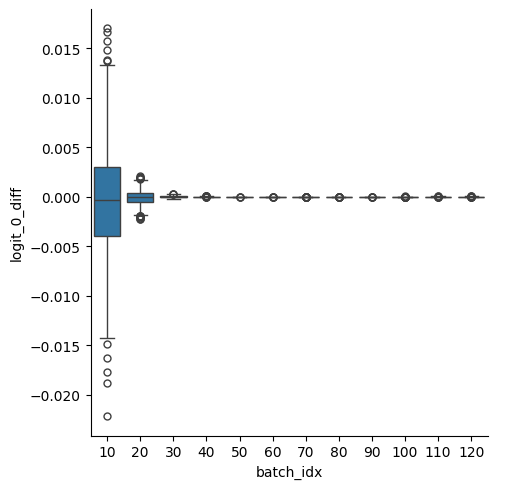

In [13]:
sns.catplot(y='logit_0_diff', x='batch_idx', data=df_holdout_merged, kind='box')


KeyboardInterrupt: 

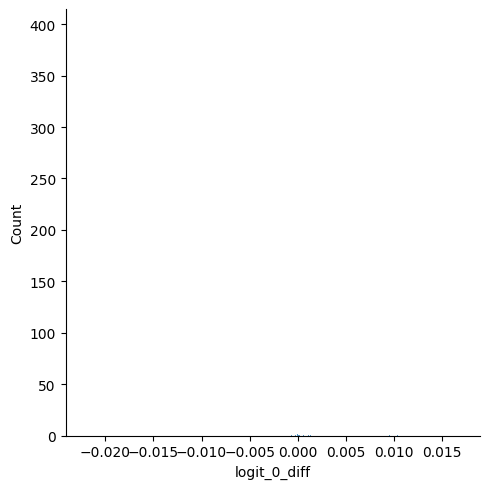

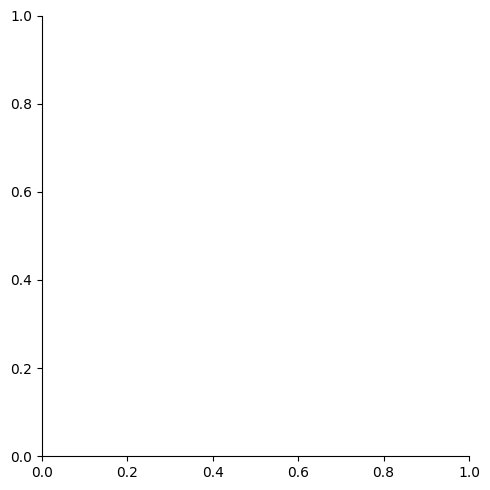

In [12]:
sns.displot(x='logit_0_diff', data=df_holdout_merged)
sns.displot(x='logit_1_diff', data=df_holdout_merged)

In [10]:
df_holdout_merged.head()

,batch_idx,epoch,image1,image2,label,prediction_1,logit_0,logit_1,correct,prediction_2,logit_0_ref,logit_1_ref
0,10,0,000015-01.jpg,000015-02.jpg,1,0,-0.011274,-0.014293,False,0,-0.007039,-0.014443
1,10,0,000015-01.jpg,000015-03.jpg,1,1,-0.335607,0.520945,True,1,-0.339268,0.522047
2,10,0,000015-02.jpg,000015-03.jpg,1,1,-0.318790,0.525761,True,1,-0.326686,0.527013
3,10,0,000047-01.jpg,000047-02.jpg,1,0,0.102205,-0.291472,False,0,0.110418,-0.300243
4,10,0,000047-01.jpg,000047-03.jpg,1,0,-0.046537,-0.049950,False,0,-0.042551,-0.047874
